<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import</a></span><ul class="toc-item"><li><span><a href="#Librairies" data-toc-modified-id="Librairies-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Librairies</a></span></li><li><span><a href="#Fonctions" data-toc-modified-id="Fonctions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Fonctions</a></span></li><li><span><a href="#Données" data-toc-modified-id="Données-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Données</a></span></li></ul></li><li><span><a href="#Faisabilité-avec-SIFT" data-toc-modified-id="Faisabilité-avec-SIFT-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Faisabilité avec SIFT</a></span><ul class="toc-item"><li><span><a href="#Test-chargement-d'image" data-toc-modified-id="Test-chargement-d'image-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Test chargement d'image</a></span></li><li><span><a href="#Création-des-Key-Points-et-Descripteurs" data-toc-modified-id="Création-des-Key-Points-et-Descripteurs-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Création des Key Points et Descripteurs</a></span></li><li><span><a href="#Création-des-features" data-toc-modified-id="Création-des-features-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Création des features</a></span></li><li><span><a href="#Réduction-des-dimensions" data-toc-modified-id="Réduction-des-dimensions-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Réduction des dimensions</a></span></li><li><span><a href="#Visualisations-des-données" data-toc-modified-id="Visualisations-des-données-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Visualisations des données</a></span></li><li><span><a href="#Avec-réduction-différente" data-toc-modified-id="Avec-réduction-différente-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Avec réduction différente</a></span></li></ul></li><li><span><a href="#Faisabilité-CNN-Transfer-Learning" data-toc-modified-id="Faisabilité-CNN-Transfer-Learning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Faisabilité CNN Transfer Learning</a></span><ul class="toc-item"><li><span><a href="#Création-du-model" data-toc-modified-id="Création-du-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Création du model</a></span></li><li><span><a href="#Création-des-features" data-toc-modified-id="Création-des-features-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Création des features</a></span></li><li><span><a href="#Réduction-des-dimensions" data-toc-modified-id="Réduction-des-dimensions-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Réduction des dimensions</a></span></li><li><span><a href="#Visualisation-des-données" data-toc-modified-id="Visualisation-des-données-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Visualisation des données</a></span></li><li><span><a href="#Confusion-matrix" data-toc-modified-id="Confusion-matrix-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Confusion matrix</a></span></li></ul></li></ul></div>

# Import 
## Librairies

In [6]:
# Builtin
import os, time, random

# Data
import numpy as np
import pandas as pd

# Graphic
import matplotlib.pyplot as plt
import seaborn as sns

# Image
import cv2 as cv
from PIL import Image
from PIL import ImageOps

# Encoder
from sklearn.preprocessing import LabelEncoder

# Réduction des dimensions
from sklearn import manifold, decomposition

# Clustering
from sklearn import cluster, metrics

# Tensorflow
import tensorflow as tf
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Dense
from keras import Model
from keras import optimizers
from tensorflow.keras.utils import to_categorical

# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Fonctions

In [2]:
def img_hist_visu(img, title, gray=False):
    if gray:
        cmap = 'gray'
    else:
        cmap = None
        
    plt.figure(figsize=(15,8))
    
    # Affichage de l'image
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.title(str('Image '+ title))
    plt.axis('off')
    
    # Affichage de l'histogramme
    plt.subplot(1, 2, 2)
    n, bins, patches = plt.hist(np.array(img).flatten(), bins=range(256))
    plt.title(str('Histogramme ' + title))
    plt.xticks(range(0,251,50))
    plt.xlabel('Valeurs des pixels')
    plt.ylabel('Fréquence')
    
    # Affichage
    plt.show()


def img_processing_visu(img):
    
    # Affichage image et histogramme
    img_hist_visu(img, "basique")
    
    # Passage en niveaux de gris
    gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_hist_visu(gray_img, "niveaux de gris", True)
    
    # Egalisation de l'histogramme
    equalized_img = cv.equalizeHist(gray_img)
    img_hist_visu(equalized_img, "égalisé(e)", True)
    
    # Filtrage du bruit et du floutage
    blurred_img = cv.GaussianBlur(equalized_img, (5,5), 0)
    img_hist_visu(blurred_img, "filtré(e)", True)
    
    # Augmentation du contraste
    normalized_img = cv.normalize(blurred_img, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)
    img_hist_visu(normalized_img, "contrasté(e)", True)    


def TSNE_visu_fct(df_tsne, title, hue):
    plt.figure(figsize=(8,5))
    sns.scatterplot(
        x="tsne1", y="tsne2", hue=hue, data=df_tsne, legend="brief",
        palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

    plt.title(title, fontsize = 30, pad = 35, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
    plt.legend(prop={'size': 14}, loc='center left', bbox_to_anchor=(1, 0.5)) 

    plt.show()
    
    
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

## Données

In [3]:
path = "../Data/Images/"

df = pd.read_csv("../Data/final.csv")

df.head()

,text,main_category,clean_text,image_name
0,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,elegance polyester multicolor abstract eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,Sathiyas Cotton Bath Towel Specifications of S...,Baby Care,cotton bath towel specification cotton bath to...,7b72c92c2f6c40268628ec5f14c6d590.jpg
2,Eurospa Cotton Terry Face Towel Set Key Featur...,Baby Care,cotton terry face towel set key feature cotton...,64d5d4a258243731dc7bbb1eef49ad74.jpg
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing,royal fashion cotton printed king sized double...,d4684dcdc759dd9cdf41504698d737d8.jpg
4,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing,print cotton floral king sized double key feat...,6325b6870c54cd47be6ebfbffa620ec7.jpg


In [6]:
le = LabelEncoder()
df["label"] = le.fit_transform(df["main_category"])

In [7]:
# Création listes globales
list_pictures = df["image_name"]
list_labels = df["main_category"].unique()

# Faisabilité avec SIFT
## Test chargement d'image

In [ ]:
list_idx = random.sample(range(1050),20)

for idx in list_idx:
    path_tmp = path + df.loc[idx, "image_name"]
    
    img = cv.imread(path_tmp)

    img_processing_visu(img)

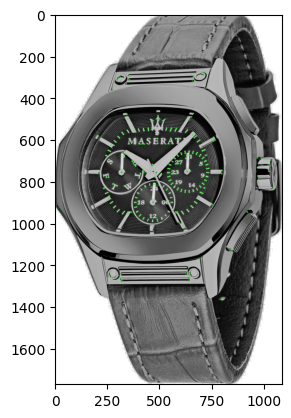

Descripteurs :  (501, 128)

[[  1.   1. 144. ...   7.   2.   0.]
 [ 42.   3.   0. ...   5.   7.   1.]
 [  7.   2.   5. ...  10.   1.   0.]
 ...
 [ 14.   0.   0. ...   5.   1.   5.]
 [  2.   4.  19. ...   4.  18.   4.]
 [ 20.   1.   3. ...   4.   5.   5.]]


In [42]:
# Détermination et affichage des descripteurs avec 1 image
sift = cv.xfeatures2d.SIFT_create(500)

# convert in gray
image = cv.imread(path + list_pictures[5], 0)

green = (0,255,0)
# equalize image histogram
image = cv.equalizeHist(image)
kp, des = sift.detectAndCompute(image, None)
img = cv.drawKeypoints(image,
                       kp,
                       0, green)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

## Création des Key Points et Descripteurs

In [8]:
# identification of key points and associated descriptors
sift_keypoints = []

start=time.time()

nb_des = 500

sift = cv.xfeatures2d.SIFT_create(nb_des)

for image_num in range(len(list_pictures)):
    
    if image_num%100 == 0 : print(image_num)
        
    path_img = path + list_pictures[image_num]

    img = cv.imread(path_img, 0) # convert in gray
    res = cv.equalizeHist(img)   # equalize image histogram
    
    # Getting keypoints and descriptors
    kp, des = sift.detectAndCompute(res, None)
    
    # Harmonize the number of descriptors by image
    if len(des) >= nb_des :
        des = des[:nb_des]
    else:
        zeros = np.zeros((500,128))
        zeros[:len(des)] = des
        des = zeros
        
    sift_keypoints.append(des)

0
100
200
300
400
500
600
700
800
900
1000


In [9]:
sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration=time.time()-start
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration, "secondes")

Nombre de descripteurs :  (525000, 128)
temps de traitement SIFT descriptor :           397.36 secondes


## Création des features

In [11]:
# Creation of histograms (features)
start=time.time()

# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-start
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             2.96 secondes


## Réduction des dimensions

In [12]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 725)
Dimensions dataset après réduction PCA :  (1050, 465)


In [13]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df["main_category"]
print(df_tsne.shape)

(1050, 3)


## Visualisations des données

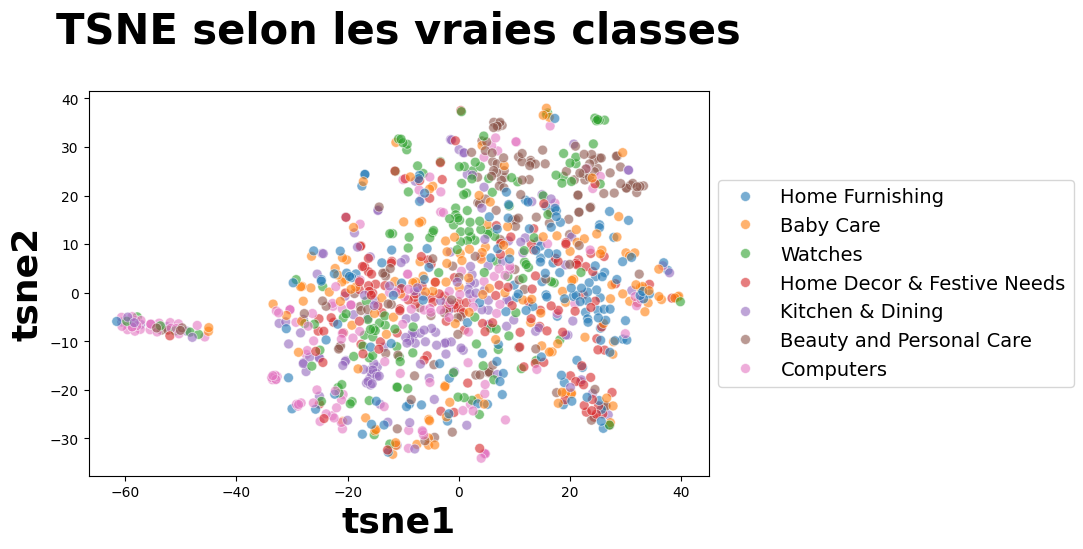

In [14]:
title = "TSNE selon les vraies classes"

TSNE_visu_fct(df_tsne, title, "class")

In [15]:
cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


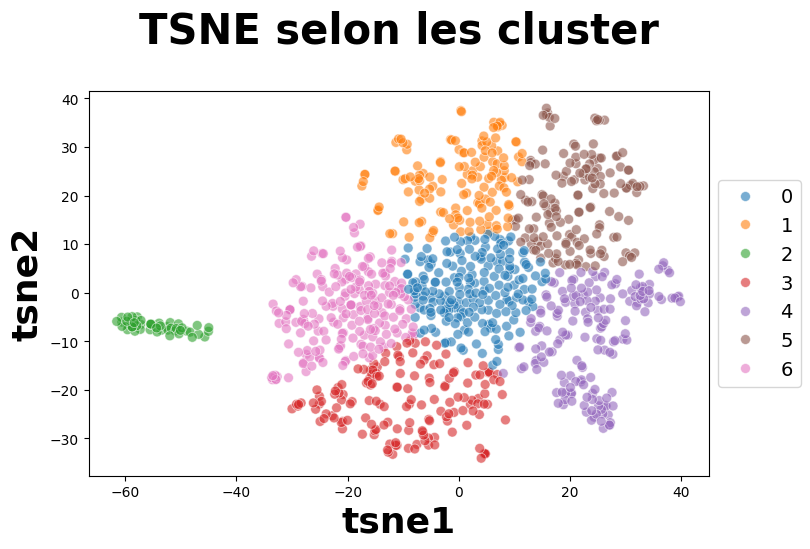

ARI :  0.043531735122461016


In [16]:
title = "TSNE selon les cluster"

TSNE_visu_fct(df_tsne, title, "cluster")

labels = df["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

## Avec réduction différente

In [27]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.95)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 725)
Dimensions dataset après réduction PCA :  (1050, 237)


In [28]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df["main_category"]
print(df_tsne.shape)

(1050, 3)


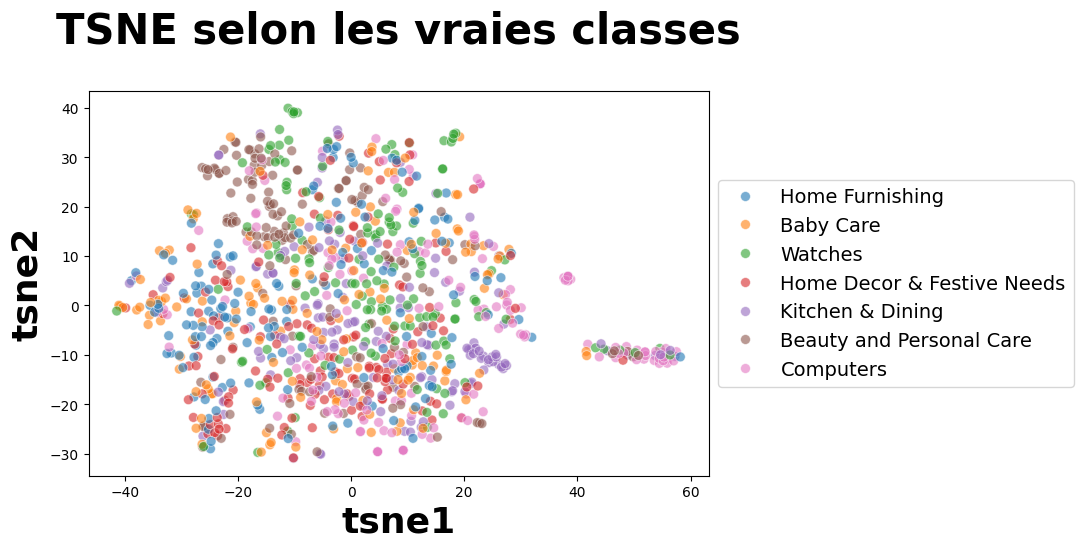

In [29]:
title = "TSNE selon les vraies classes"

TSNE_visu_fct(df_tsne, title, "class")

In [30]:
cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


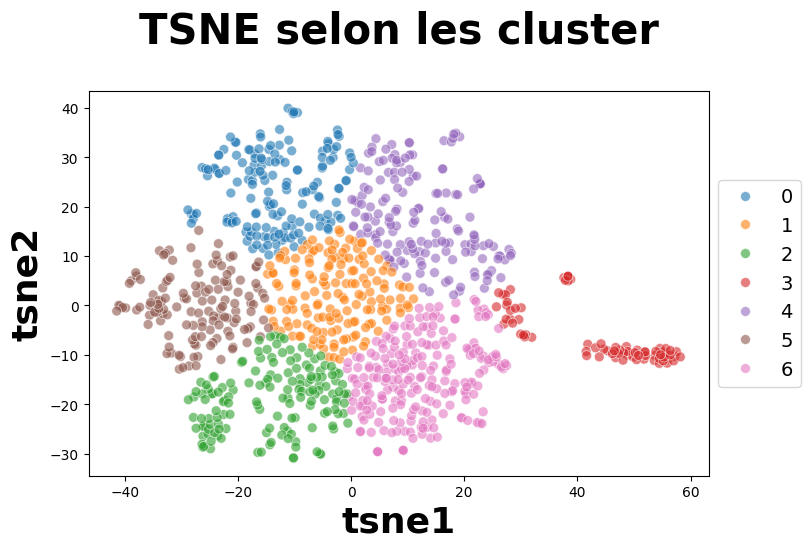

ARI :  0.06311606885465847


In [31]:
title = "TSNE selon les cluster"

TSNE_visu_fct(df_tsne, title, "cluster")

labels = df["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

# Faisabilité CNN Transfer Learning
## Création du model

In [17]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## Création des features

In [18]:
images_features = []
i=0 
for image_file in list_pictures :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(path+image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
100
200
300
400
500
600


C:\Users\Thomas\AppData\Local\pypoetry\Cache\virtualenvs\projet6-mnlG3Dat-py3.11\Lib\site-packages\PIL\Image.py:3182: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000


(1050, 4096)

## Réduction des dimensions

In [19]:
print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(1050, 4096)
(1050, 803)


In [20]:
start = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-start
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

temps de T-SNE :             7.39 secondes


## Visualisation des données

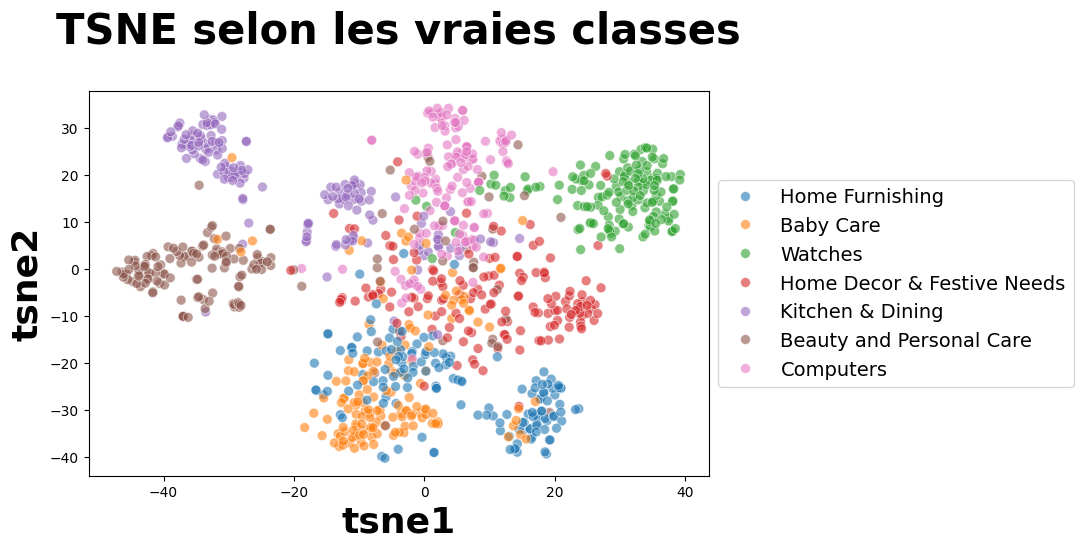

In [21]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = df["main_category"]

title = "TSNE selon les vraies classes"

TSNE_visu_fct(df_tsne, title=title, hue="class")

In [22]:
cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=7, n_init=100)

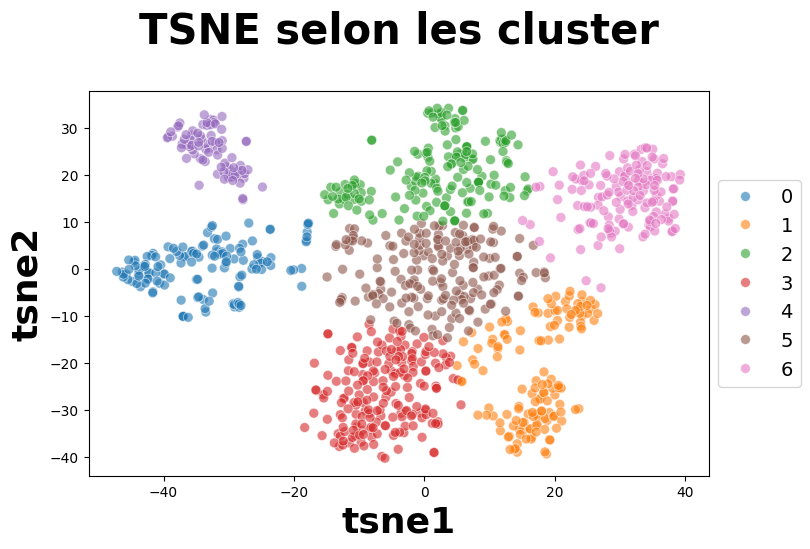

ARI :  0.45000113558089455


In [23]:
df_tsne["cluster"] = cls.labels_

title = "TSNE selon les cluster"

TSNE_visu_fct(df_tsne, title, "cluster")

labels = df["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

## Confusion matrix

In [24]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[  3   8   1 109   1  27   1]
 [117   5   9   5   1  12   1]
 [  1   0 111   1   0  36   1]
 [  1  57   5   2   0  77   8]
 [  0  68   0  76   0   6   0]
 [ 10   0  32   0  78  30   0]
 [  0   0  13   0   0   2 135]]


In [25]:
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [1 4 2 0 5 3 6]
[[109   3   1  27   8   1   1]
 [  5 117   9  12   5   1   1]
 [  1   1 111  36   0   0   1]
 [  2   1   5  77  57   0   8]
 [ 76   0   0   6  68   0   0]
 [  0  10  32  30   0  78   0]
 [  0   0  13   2   0   0 135]]

              precision    recall  f1-score   support

           0       0.56      0.73      0.64       150
           1       0.89      0.78      0.83       150
           2       0.65      0.74      0.69       150
           3       0.41      0.51      0.45       150
           4       0.49      0.45      0.47       150
           5       0.97      0.52      0.68       150
           6       0.92      0.90      0.91       150

    accuracy                           0.66      1050
   macro avg       0.70      0.66      0.67      1050
weighted avg       0.70      0.66      0.67      1050



<Axes: >

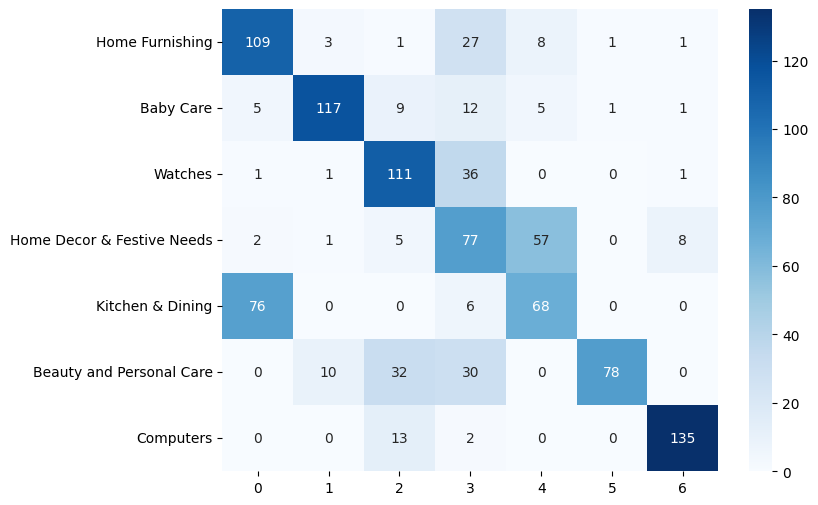

In [26]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (8,6))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues")